In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

## Part 1: Dataset cleaning and pre-processing ##

Given Part 1 is a data exploration task (and also due to the nature of the questions asked in the assignment), a Jupyter notebook has been used for convinience. If such functionality was required for software / package delivery,  a more sophisticated, *object-oriented* approach would have been taken (e.g. see description in Task 1.1).

The data loading scheme used in this notebook is **not** the scheme used for training models (in Part 2). 
Those schemes benefit from a more memory efficient data loading scheme, where data batches are fetched on the fly (easier on older PCs like mine).

In the final cell, the notebook will create a new csv (`preprocess_tgca.csv`) saved in the `/data/preprocessed/` directory (it is useful keeping copies of the raw + preprocessed data for reference).

### Task 1.1 ###

To store the tabular data I thought about writing a 'Table' class (with convinent methods to add/retrieve rows etc.). A rudimentary example:

```
class Table(object):
    def __init__(self):
        self.rows =  []   
        self.index = {} # for faster direct lookup for row by ID

    def add_row(self, row):
        self.rows.append(row)
        self.index[row['ID']] = row

    def get_row(self, ID):
        return self.index[ID]


```

Then, to load csv file natively:

```
import csv

with open(PATH) as file:
    reader = csv.DictReader(file)
    table = Table()
    
    for i, row in enumerate(reader):
        table.add_row(
            {
                "ID": "patient_{}".format(i + 1), 
                "Features": {k:v for k,v in row.items() if k not in ["treatment", "outcome"]},
                "Treatment": row["treatment"],
                "Outcome": row["outcome"],
            }
        )


```

E.g. retrieving a patient:

```
table.get_row("patient_1")

Output:
{'ID': 'patient_1',
 'Features': {'gene_0': '0.0',
  'gene_1': '0.02217902106061914',
  'gene_2': '0.01999148964328371',
  'gene_3': '0.0286672972445759',
  'gene_4': '',
  'gene_5': '0.0014867656754875766',
  ...},
 'Treatment': '2',
 'Outcome': '25.67483692247939'}
  
  
```




Subsequently, core functionalities (such as those discussed in later questions) may be added as class methods. 

While this is certainly possible as a means of avoiding non-native python packages or designing a minimal, flexible object for a particular package/purpose, for now, pandas is convinient for the task at hand (data exploration). 

In [2]:
PATH = "/home/user/work/data/raw/tcga.csv"

# load csv
df = pd.read_csv(PATH)

# rename index for clarity
df.index = ["patient_{}".format(i + 1) for i, _ in df.iterrows()]

# display head
df.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_3992,gene_3993,gene_3994,gene_3995,gene_3996,gene_3997,gene_3998,gene_3999,treatment,outcome
patient_1,0.0,0.022179,0.019991,0.028667,NaN,0.001487,0.014651,0.007045,0.020046,0.004194,...,0.001817,0.023123,0.019850,0.023891,0.020087,0.016228,0.015739,0.021505,2,25.674837
patient_2,0.0,0.027894,0.014104,NaN,NaN,0.011135,NaN,0.015889,0.021798,0.013605,...,0.010615,0.022372,0.017864,0.021327,0.019718,0.016196,0.016092,0.015684,2,27.501519
patient_3,NaN,0.028332,0.016133,NaN,0.009922,0.013941,0.013031,NaN,0.021257,0.005755,...,0.012578,0.023699,NaN,0.018225,NaN,0.016961,0.018936,0.019644,1,15.950662
patient_4,0.0,0.015878,0.015199,0.017267,NaN,0.009016,0.022765,0.020222,NaN,0.016970,...,0.017885,0.022265,0.018220,NaN,0.022580,0.015747,0.019841,0.010349,2,15.708792
patient_5,0.0,0.031826,0.018024,0.027217,NaN,0.009153,0.009873,NaN,0.019805,0.010973,...,0.008122,0.025017,NaN,0.015463,0.012341,0.020715,0.015846,0.015224,1,14.753644


In [3]:
print("Number of patients:", len(df))
print("Number of features:", len([col for col in df if col.startswith('gene')]))

Number of patients: 9659
Number of features: 4000


### Task 1.2 ###

In [4]:
def max_value(feature):
    """
    Computes the highest value among all patients for a feature.
    
    Parameters
    ----------
    feature  : str
        The feature to find max value.
        
    Returns
    -------
    float
    
    """
    return df[feature].max()


max_value("gene_0")

0.0290394998953435

### Task 1.3 ###

In [5]:
def max_value_idx(feature):
    """
    Computes the highest value and corresponding patient(s) for a feature.
    
    Parameters
    ----------
    feature  : str
        The feature to find max value.
        
    Returns
    -------
    tuple (float, list)
    
    """
    
    # in case there is more than one max value
    patient_idxs = df[df[feature] == df[feature].max()].index
    patient_idxs = list(patient_idxs)
    
    return df[feature].max(), patient_idxs


max_value_idx("gene_0")

(0.0290394998953435, ['patient_8599'])

### Task 1.4 ###

Domain knowledge would be helpful in this regard to evaluate the randomness of missing values (e.g. poor hybridisation, susceptibility ot contaminants/artifacts).

From a statistical perspective, it can be important to distinguish Missing at Random (MAR) vs Missing Not at Random (MNAR). Imputation schemes may operate on such assumptions (e.g. multiple imputation/maximum mikelihood assume the data are at least missing at random.)

The idea can be investigated in more depth than what is displayed below (e.g. running t-tests / chi-square tests to check if variable missingness is related to other variables, or Little's test to evaluate if data is Missing Completely at Random.). Only a quick plot and nullity correlation matrix is computed below.

In [6]:
# covariates
df_cov = df[[col for col in df if col.startswith('gene')]]

Avg missingness: 9.996190081789004 %


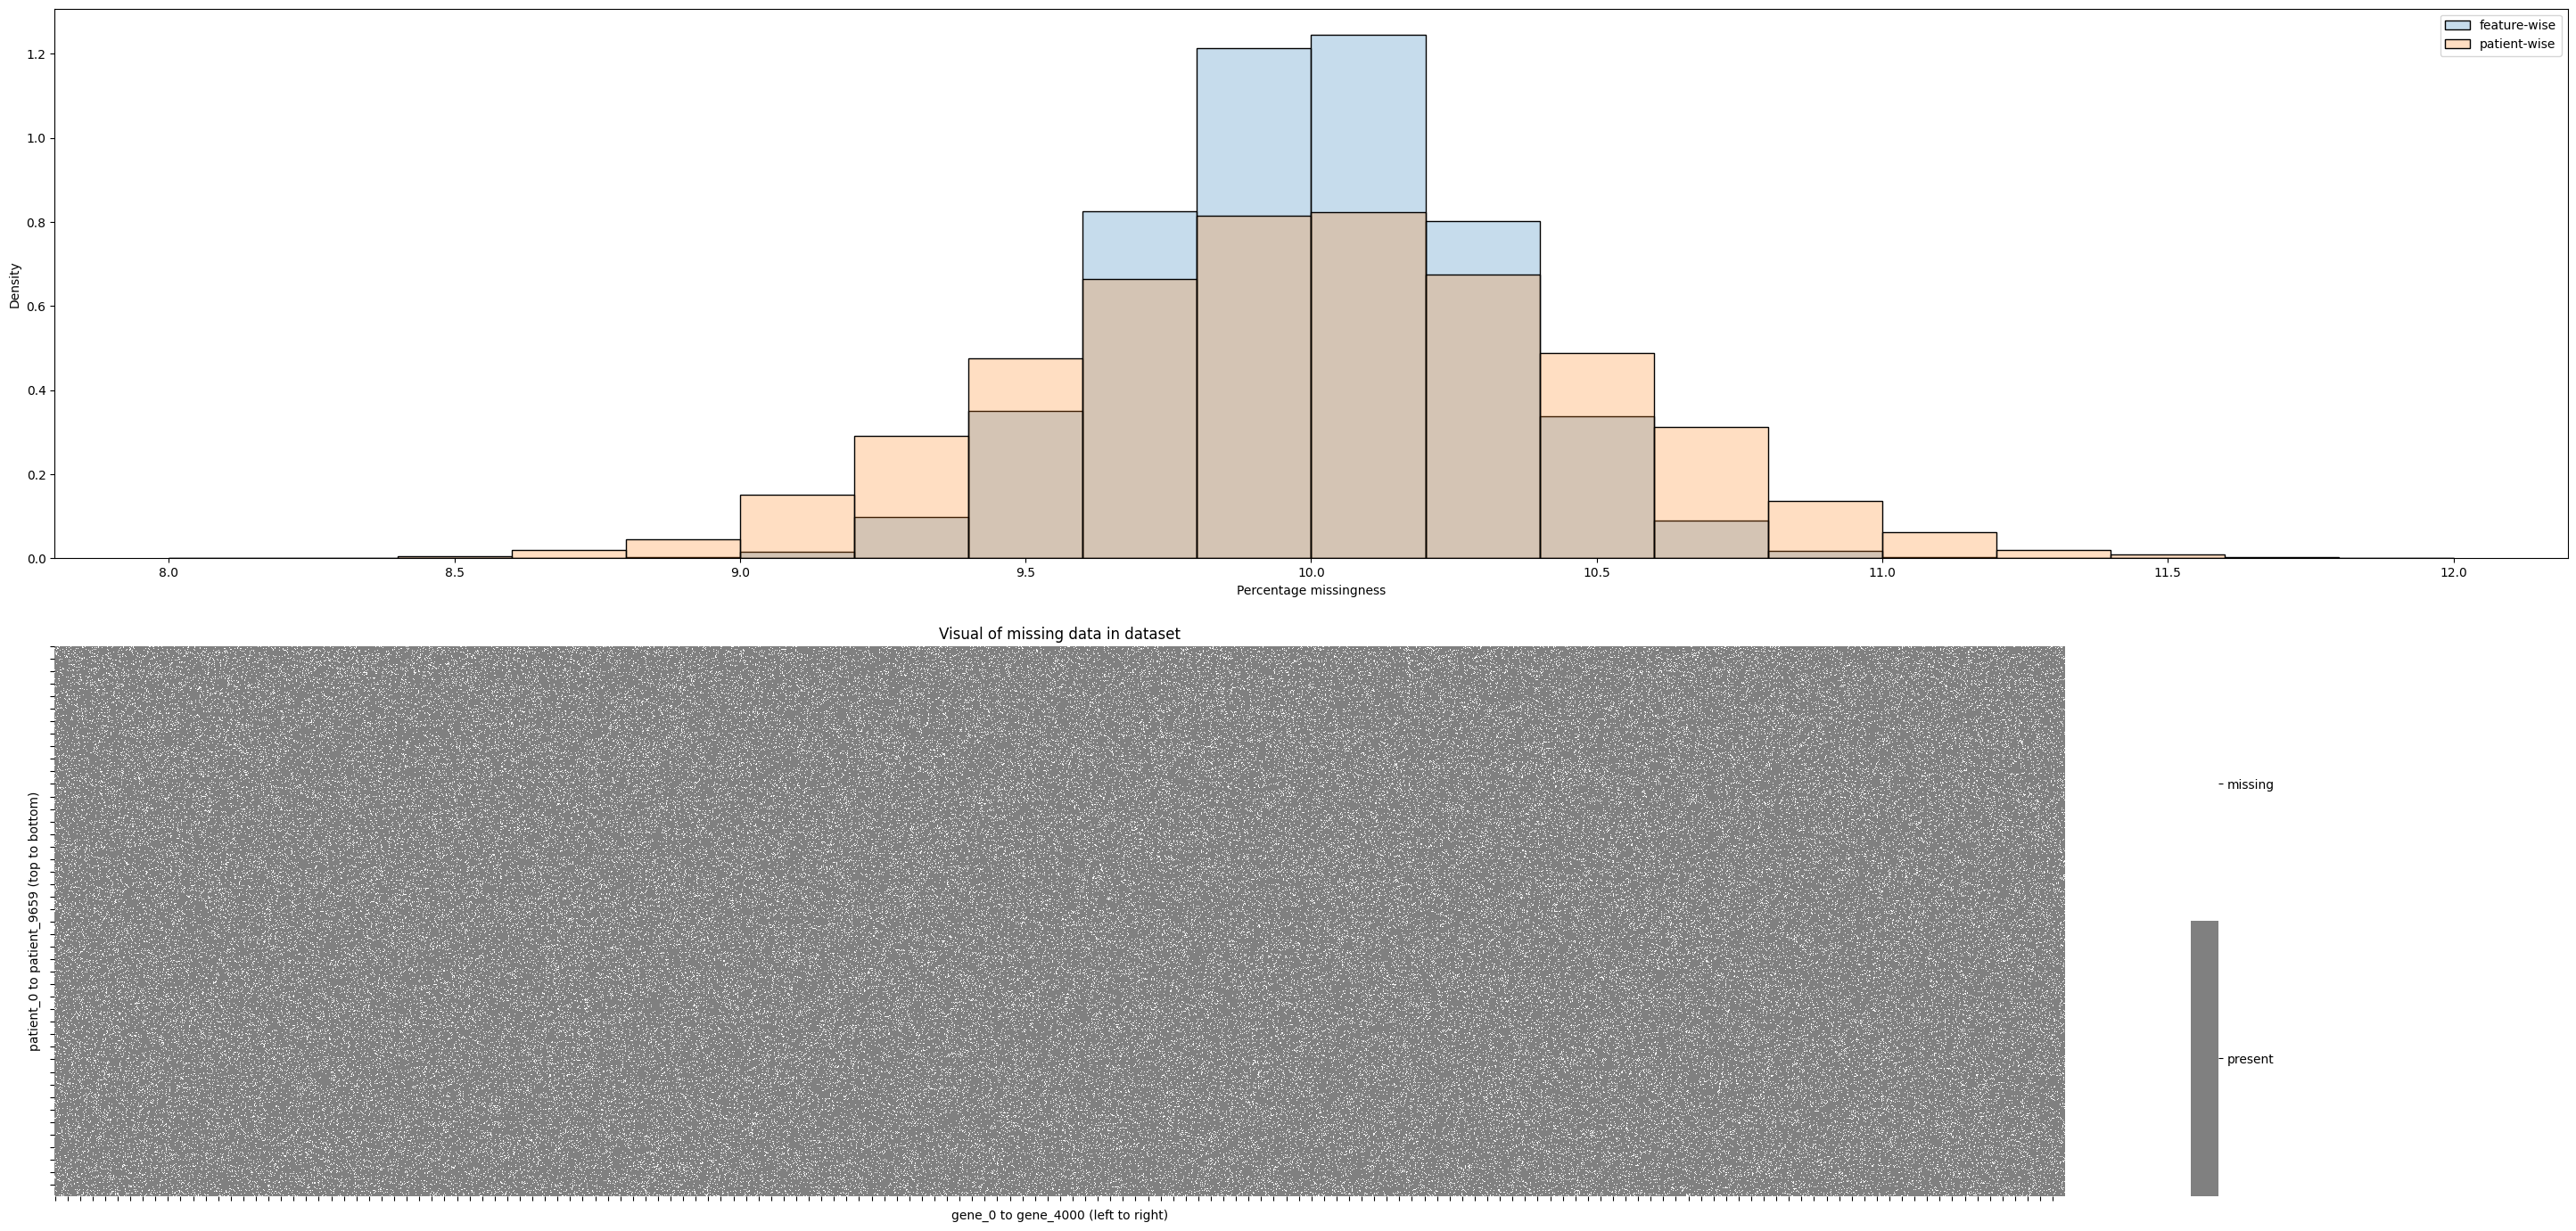

In [7]:
# feature-wise missingness
percent_missing_feat = df_cov.isnull().mean() * 100

# patient-wise missingness
percent_missing_idx = df_cov.isnull().mean(axis=1) * 100

# visualize
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize=(30, 15))
fig.tight_layout(pad=5.0)

# histogram of percentage missingness
num_bin = 20
bin_lims = np.linspace(8, 12, num_bin + 1)
sns.histplot(
    percent_missing_feat, 
    bins = bin_lims, 
    ax = ax1, 
    stat = "density", 
    alpha = 0.25, 
    label = "feature-wise")
sns.histplot(
    percent_missing_idx, 
    bins = bin_lims, 
    ax = ax1, 
    stat = "density", 
    alpha = 0.25, 
    label = "patient-wise")
ax1.legend()
ax1.set(xlabel = 'Percentage missingness')
ax1.set(xlabel = 'Percentage missingness')

# heat map of missing values
# somewhat redundent since matrix is so big... but just checking overall pattern
colours = ["gray", "white"] 
cmap = LinearSegmentedColormap.from_list('Custom', colours, len(colours))
sns.heatmap(
    df_cov.isnull(),
    cmap = cmap,
    ax = ax2)
colorbar = ax2.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(["present", 'missing'])
ax2.set(title = "Visual of missing data in dataset")
ax2.set(xlabel = "gene_0 to gene_4000 (left to right)")
ax2.set(ylabel = "patient_0 to patient_9659 (top to bottom)")
ax2.set_yticklabels([])
ax2.set_xticklabels([])

# patient wise average missingness
print("Avg missingness:", percent_missing_idx.mean(), "%")

In [8]:
# visually, the above seems somewhat randomly distributed
# a full nullity correlation visual is difficult to display so just returning top 0.5% highest values:

nullity_corr = pd.DataFrame(
    np.corrcoef(
        df_cov.isnull().values, 
        rowvar=False), 
    columns=df_cov.columns,
    index=df_cov.columns)


def n_largest_indices_tril(n=2):
    """
    Returns the genes corresponding to the n largest 
    values in lower triangle of nullity correlation matrix.
    
    Parameters
    ----------
    n  : int
        Number of largest values
        
    Returns
    -------
    list of tuples
    
    """
    x = np.array(nullity_corr)
    
    m = np.array(nullity_corr).shape[0]
    r, c = np.tril_indices(m, -1)
    idx = x[r, c].argpartition(-n)[-n:]
    
    return list(zip(r[idx], c[idx]))


print("Top 0.5% nullity correlation score (gene pair, score):")

idx = n_largest_indices_tril(n=20)
scores = [nullity_corr.values[i][j] for i, j in idx]

for (i, j), score in zip(idx, scores):
    print("(gene_{},".format(i), "gene_{})".format(j), score)


Top 0.5% nullity correlation score (gene pair, score):
(gene_3517, gene_1337) 0.04902616780667915
(gene_2689, gene_2223) 0.04932032689032456
(gene_3470, gene_2358) 0.04948103722971762
(gene_2366, gene_320) 0.04912794992922011
(gene_1355, gene_266) 0.049356120083431786
(gene_2764, gene_1956) 0.04955415892621988
(gene_1940, gene_1464) 0.05234132553465714
(gene_3202, gene_2141) 0.049862191460225816
(gene_2729, gene_486) 0.050711314208309655
(gene_2246, gene_1105) 0.05202840271106046
(gene_2670, gene_411) 0.05115963039906024
(gene_3475, gene_2042) 0.04983300357239565
(gene_2625, gene_1597) 0.053115631262311724
(gene_1316, gene_961) 0.053371965973962085
(gene_3488, gene_3484) 0.0526426068348654
(gene_165, gene_36) 0.055309361044120424
(gene_3074, gene_1644) 0.05131398177227857
(gene_2095, gene_933) 0.05061890467954371
(gene_3858, gene_3616) 0.051796888037498365
(gene_3976, gene_2552) 0.0516172974548498


### Task 1.5 ###

Outcome seems to be a continous variable, so computation of mutual information should be for continuous variables.

Not sure whether pre-normalized features were integers (e.g. count or gene presence boolean). There may have been complexity in the normalization scheme (e.g. depending on gene length / sequencing depth etc.), so I'll treat the features as continuous in this task. In the case that the features were a distribution of *integers*, the algorithm would be:
- compute Shannon entropy of discrete variables Y (features)
- discretize continous variable X (target), and compute conditional entropy, H(Y|X)
- mutual information = entropy(Y) - conditional_entropy(X, Y)

E.g. (inspired from https://gist.github.com/elsonidoq/4230222)

```
from collections import defaultdict

def mutual_information(feature):
    
    mi = {}
    
    for treatment in range(3):
        x = df["outcome"][df["treatment"] == treatment]
        y = df[feature][df["treatment"] == treatment]
        
        # removing NaN from features
        x = x[y.notnull()]
        y = y[y.notnull()]
        
        mi[treatment] = entropy(y) - conditional_entropy(x,y)
        
    return mi


def conditional_entropy(x, y):
    """
    x: vector of numbers
    y: vector of integers
    
    Computes conditional Shannon entropy, H(Y|X).
    """
    
    # discretize X 
    hx, bx = np.histogram(x, bins=int(x.size/10), density=True)

    Py = compute_distribution(y)
    Px = compute_distribution(np.digitize(x, bx))

    result = 0
    for iy in set(y):
        # P(X | Y)
        x1 = x[y == iy]
        cond_Pxy= compute_distribution(np.digitize(x1, bx))

        for k, v in cond_Pxy.iteritems():
            result += (v * Py[iy] * (np.log2(Px[k]) - np.log2(v * Py[iy])))
    
    return result
        
def entropy(y):
    """
    Computes Shannon entropy of discrete variables
    """
    
    # P(Y)
    Py = compute_distribution(y)
    result = 0.0
    for k, v in Py.iteritems():
        result += v * np.log2(v)
    return -result


def compute_distribution(v):
    """
    v: vector of integer values
    
    Returns a dictionary with the probability of each value
    computed as the frequency of occurrence.
    
    """
    d = defaultdict(int)
    for i in v: d[i] += 1
    s = float(sum(d.values()))
    return dict((k, v/s) for k, v in d.items())

```



For the *continuous* features, I'll use sklearn's regressor:


In [9]:
def mutual_information(feature):
    """
    Mutual information regression for between feature and
    outcome, assuming continuous features and targets.  
    
    Parameters
    ----------
    feature  : str
        The feature to find mutual informatiion for.
        
    Returns
    -------
    dict
        A dictionary organised with keys out outcome.

    """
    
    mi = {}
    
    for treatment in range(3):
        x_df = df[feature][df["treatment"] == treatment]
        y_df = df["outcome"][df["treatment"] == treatment]
       
        # masking NaN features
        x = x_df[x_df.notnull()].to_numpy().reshape(-1, 1)
        y = y_df[x_df.notnull()].to_numpy()
        
        mi[treatment] = mutual_info_regression(x, y, discrete_features=False).item()
        
    return mi

mutual_information("gene_1")

{0: 0, 1: 0.029650008618490986, 2: 0.003814063615974028}

### Task 1.6 ###

It is important to distiguish biological outliers and experimental ('batch effect') outliers. Removing biological outliers will result in underestimation of natural biological variances and could bias our models later on.

E.g. if this was part of differential expression analysis, the normalization scheme may have given us some information about outliers (e.g. DESeq2 and edgeR).

Without further domian knowledge (and for the current task), we could perform 'single sample' statistical tests for feature-wise outlier detection. The flow of the analysis will be:
- check normality (classical outlier detection usually depends on a reference distribution (typically a normal distribution), from which deviation/confidence scores are computed. I'll use a probability plot against a theoretical normal distribution as a qualitative visual. **Note**: since the sample size is large, normality tests to *verify* if data is normally distributed (such as Shapiro-Wilk tests) would detect very small differences between the null distribution, which would likely result in a rejection of the null hypothesis. This leads into a sticky situation where we ask ourselves "how normal is normal enough?" for the analysis to continue...
- compute modified (robust) z-scores (based on median and MAD) as a means for outlier detection. Scores less than -3.5 or greater than 3.5 are labeled as *potential* outliers (convention from [Iglewicz and Hoaglin](https://hwbdocuments.env.nm.gov/Los%20Alamos%20National%20Labs/TA%2054/11587.pdf))

(As mentioned the above approach depends on normally distributed prior assumption. As for further investigation, Bayesian/probabilistic methods may be interesting to extend flexibility in the analysis...).

(I also understand ML methods such as Isolation forests on sklearn is also viable).

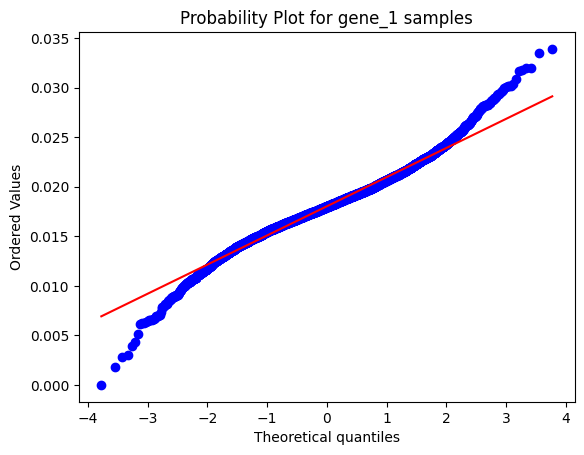

In [10]:
def plot_pp(feature):
    """
    Generates a probability plot of sample data against the quantiles 
    of a normal distribution.

    Parameters
    ----------
    feature  : str
        The feature to plot probability plot for.
        
    Returns
    -------
    matplotlib.pyplot.figure
    
    """
    
    # masking NaN features
    x = df[feature]
    x = x[x.notnull()]
    
    fig, ax = plt.subplots()
    stats.probplot(x, dist="norm", plot=ax)
    ax.set_title("Probability Plot for {} samples".format(feature))

    
plot_pp("gene_1")

The distribution seems heavy tailed.

In [11]:
def modified_zscore(feature, consistency_correction=1.4826):
    """
    Returns the modified z-scores for samples in a given feature. 
    
    The consistency_correction factor converts MAD to standard deviation
    for given distribution (default 1.4826 is the convention if underlying 
    data is normally distributed)
    
    Parameters
    ----------
    feature  : str
        The feature to compute modified z-score for.
    consistency_correction  :  float
        The consistency_correction factor.
        
    Returns
    -------
    pandas.DataFrame
    
    """
    
    # masking NaN features
    x = df[feature]
    x = x[x.notnull()]
    
    x_median = x.median()
    dev_from_median = x - x_median
    mad = np.abs(dev_from_median).median()
    
    mod_zscore = dev_from_median / (consistency_correction * mad)
    
    return mod_zscore
    

def detect_outliers(feature, tol=3.5):
    """
    Returns boolean dataframe for whether samples in a feature are
    regarded as a potential outliers by computing their modified
    z-scores.
    
    By default the tolerance tol modified z-score is 3.5 (meaning scores 
    less than -3.5 or greater than 3.5 are considered outliers).
    
    Parameters
    ----------
    feature  : str
        The feature to compute modified z-score for.
    tol  :  float
        Absolute value of cutoff for outlier detection.
        
    Returns
    -------
    pandas.DataFrame
    
    """
    
    mod_zscores = modified_zscore(feature)
    df_outliers = ~mod_zscores.between(-tol, tol, inclusive="neither")
    
    return df_outliers


print(detect_outliers("gene_1"))
print("number of detected outliers:", detect_outliers("gene_1").sum())

patient_1       False
patient_2        True
patient_3        True
patient_4       False
patient_5        True
                ...  
patient_9654    False
patient_9655    False
patient_9657    False
patient_9658    False
patient_9659    False
Name: gene_1, Length: 8665, dtype: bool
number of detected outliers: 127


### Task 1.7 ###
See Part 2.7

### Task 1.8 ###
Time restrictions :(

### Task 2.1 ###

There are perhaps a few approaches we could take to impute the missing values, broadly catagorized into: 
- **domian knowledge assisted imputation** (i.e. incorporating information about the underying biological process / experimental data collection procedure can help regularize imputation estimates, e.g. functionally related genes may express in a particular fashion for a given experimental stimuli)
- **global imputation** (assuming a global covariance structure among all genes, we could use algorithms such as SVD, BPCA,  or simple median/mean imputation) 
- **local imputation** (assuming there is dominant local similarity structures, where subsets of genes exhibit high correlation, we could use algorithms such as KNN, local least squares)

As mentioned previously, it is important to also evaluate if data is MAR, MNAR, MCAR etc. before choosing an imputation scheme. For now, we will assume data is missing at least at random (from the short, perhaps non-rigerous analysis above) and continue with choosing a scheme.


Due to lack of domain information, we'll stick to a data-driven approach. The flow will be the following:
- conduct simple median imputation as a baseline
- evaluate the correlation structure - (global/local) via an entropy measure on the covariance matrix ([inspiration](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-12))
- depending on correlation structure, adjust imputation scheme if necessary


(Since missing values per feature seem to be distributed within a tight 9-11% range, a "missingness" cutoff won't be used to remove features beforehand for now.)

In [12]:
# fill NaN with median of each gene
imputer = SimpleImputer(strategy="median")
df_impute = pd.DataFrame(
    imputer.fit_transform(df_cov),
    columns=df_cov.columns,
    index=df_cov.index)

# covariance matrix
df_cov_mat = pd.DataFrame(
    np.cov(
        df_impute.values.T, 
        bias=True), 
    columns=df_cov.columns,
    index=df_cov.columns)

# compute covariance entropy
cov_eigvalues, _ = np.linalg.eig(df_cov_mat.values)
p = np.sqrt(cov_eigvalues) / np.sqrt(cov_eigvalues).sum()
cov_entropy = - np.sum(p * np.log2(p)) / np.log2(len(p))

print("covariance entropy = ", cov_entropy)

covariance entropy =  0.9512518154807644


Note that the entropy measure is between 0 - 1. The computed value for the dataset is large (closer to 1) suggesting the eigenvalues of the covariance matrix have similar magnitudes (as opposed to few eigenvalues that are distinctively larger than the others). It may also suggest that the data may not readily be reduced to a low-dimensional space. This may support the use of a global imputation scheme.


We'll stick with a simple median imputation (note: [this](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-015-0494-3) paper was interesting for the problem of classical classification/clustering. Though the premise of our problem / data may be different and could benefit from further analysis).


To address the potential outliers, we can introduce a cap at the modified z-score boundaries (i.e -3.5, 3.5 tolerance). (Usually I wouldn't be confident about this without more domain knowledge... but I'll try it for this task). Care is taken with sparse features (features that are mostly zero) which might have modified z-score boundaries that are also zero (essentially zeroing everything in the feature). I do this on the assumtion that such sparse features in itself might provide some predictive power when they are present.

In [13]:
# limit boudaries for modified z-score
def modified_zscore_caps(feature, tol=3.5, consistency_correction=1.4826):
    """
    Returns the upper and lower limit for samples in a given feature
    for a given modified z-score tol boundary .
    
    The consistency_correction factor converts MAD to standard deviation
    for given distribution (default 1.4826 is the convention if underlying 
    data is normally distributed)
    
    Parameters
    ----------
    feature  : str
        The feature to compute modified z-score for.
    tol  :  float
        Absolute value of cutoff for outlier detection.
    consistency_correction  :  float
        The consistency_correction factor.
        
    Returns
    -------
    tuple 
        upper and lower modified z-score cap given tol
    
    """
    
    # masking NaN features
    x = df[feature]
    x = x[x.notnull()]
    
    x_median = x.median()
    
    dev_from_median = x - x_median
    mad = np.abs(dev_from_median).median()
    
    upper_limit = x_median + tol * (consistency_correction * mad)
    lower_limit = x_median - tol * (consistency_correction * mad)
    
    return upper_limit, lower_limit


# maybe a better way to do this...
def cap_df(tol=3.5):
    """
    Returns capped dataframe using the upper and lower limit 
    computed by the modified z-score statistic for a given tol cutoff.
    
    Parameters
    ----------
    tol  :  float
        Absolute value of cutoff for outlier detection.
        
    Returns
    -------
    pandas.DataFrame 

    """
    
    upper_limits = []
    lower_limits = []
    feats_to_clip = []

    for feat in df_cov:
        upper, lower = modified_zscore_caps(feat, tol=tol)

        if upper == 0 and lower == 0:
            pass
        else:
            upper_limits.append(upper)
            lower_limits.append(lower)
            feats_to_clip.append(feat)

    df_impute[feats_to_clip] = df_impute[feats_to_clip].clip(lower_limits, upper_limits)
    
    return df_impute


df_capped = cap_df(tol=3.5)
print(df_capped)

              gene_0    gene_1    gene_2    gene_3    gene_4    gene_5   
patient_1        0.0  0.022179  0.019991  0.028667  0.017053  0.001487  \
patient_2        0.0  0.026614  0.014104  0.020890  0.017053  0.011135   
patient_3        0.0  0.026614  0.016133  0.020890  0.009922  0.013941   
patient_4        0.0  0.015878  0.015199  0.017267  0.017053  0.009016   
patient_5        0.0  0.026614  0.018024  0.027217  0.017053  0.009153   
...              ...       ...       ...       ...       ...       ...   
patient_9655     0.0  0.020901  0.028193  0.025709  0.016930  0.019892   
patient_9656     0.0  0.017985  0.023331  0.027880  0.024217  0.022763   
patient_9657     0.0  0.019438  0.016772  0.022881  0.020841  0.022703   
patient_9658     0.0  0.023508  0.025859  0.026758  0.019333  0.025099   
patient_9659     0.0  0.024799  0.020910  0.028478  0.019090  0.027360   

                gene_6    gene_7    gene_8    gene_9  ...  gene_3990   
patient_1     0.014651  0.007045  0.020

As an addition, before saving this processed dataset for the next task, we will standardize the dataset with the normal z-score.

In [14]:
# z-score standardization by removing the mean and scaling to unit variance
scaler = StandardScaler()
df_standard = pd.DataFrame(
    scaler.fit_transform(df_capped),
    columns=df_impute.columns,
    index=df_impute.index)

# save preprocessed dataset
df[[col for col in df if col.startswith('gene')]] = df_standard
df = df.reset_index(drop=True)
df.to_csv("/home/user/work/data/preprocessed/tgca_preprocessed.csv", index=True)